## Seaborn: bar chart ##

Procediamo analogamente al caso precedente dello scatterplot.

In [1]:
# librerie
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

**lettura del datatset dagli Open Data del Comune di Milano**

In [130]:
#lettura del dataset
df_py=pd.read_csv("datasets/comune_milano/qaria_datoariagiornostazione_2022-10-01.csv", 
    sep=";")
df_py

,stazione_id,data,inquinante,valore
0,1,2022-09-30,NO2,NaN
1,2,2022-09-30,C6H6,1.8
2,2,2022-09-30,NO2,47.0
3,2,2022-09-30,O3,63.0
4,2,2022-09-30,PM10,21.0
...,...,...,...,...
4859,7,2022-01-03,O3,11.0
4860,7,2022-01-03,PM10,57.0
4861,8,2022-01-03,C6H6,NaN
4862,8,2022-01-03,CO_8h,NaN


**verifica del tipo di dati e conversione**

In [131]:
df_py.dtypes

stazione_id      int64
data            object
inquinante      object
valore         float64
dtype: object

A differenza di R (readr), pandas ha interpretato correttamente i valori della colonna `valore` definendola come numerica.<br>
Anche in questo caso il formato della colonna `data` va convertito in `datetime`.<br>
Usiamo il formato esplicito, molto semplice.

In [132]:
df_py["data"]=pd.to_datetime(df_py["data"], format="%Y-%m-%d")

In [133]:
df_py.dtypes

stazione_id             int64
data           datetime64[ns]
inquinante             object
valore                float64
dtype: object

## Valori mancanti

Controlliamo i **valori mancanti**. Ne esistono parecchi nella colonna `valore`. 

In [62]:
#valori mancanti
df_py[df_py.isna().any(axis=1)]

,stazione_id,data,inquinante,valore
0,1,2022-09-30,NO2,NaN
14,5,2022-09-30,NO2,NaN
15,5,2022-09-30,O3,NaN
24,8,2022-09-30,C6H6,NaN
25,8,2022-09-30,CO_8h,NaN
...,...,...,...,...
4851,5,2022-01-03,NO2,NaN
4852,5,2022-01-03,O3,NaN
4861,8,2022-01-03,C6H6,NaN
4862,8,2022-01-03,CO_8h,NaN


Escludiamo le righe con valori mancanti, non ci servono.

In [63]:
df_py=df_py[~df_py.isna().any(axis=1)]
df_py

,stazione_id,data,inquinante,valore
1,2,2022-09-30,C6H6,1.8
2,2,2022-09-30,NO2,47.0
3,2,2022-09-30,O3,63.0
4,2,2022-09-30,PM10,21.0
5,2,2022-09-30,PM25,11.0
...,...,...,...,...
4856,6,2022-01-03,PM10,77.0
4857,6,2022-01-03,PM25,66.0
4858,7,2022-01-03,NO2,71.0
4859,7,2022-01-03,O3,11.0


## Operazioni su gruppi e indice: `groupby()`

Come nel caso precedente di ggplot2, vogliamo mostrare per ogni valore della variabile categorica `inquinante` il totale di prodotto inquinante (somma di `valore`, asse `y`), su tutto il periodo della rilevazione.<br>
Vediamo come usare i gruppi in Python. Esiste la corrispondente funzione `groupby()` di pandas che segue la stessa logica della `group_by()` di R: definisce gruppi rispetto ai valori di una o più variabili e applica una o più operazioni a tali gruppi. <br>
Cambia la sintassi e soprattutto con Python abbiamo la gestione esplicita dell'**indice** creato dalla `groupby()`, eventualmente su più livelli (*multiindex*).

**NOTA BENE** La sintassi con la doppia parentesi quadra (`[["valore"]]`) produce un data frame come risultato. Potevamo usare la sintassi con singola parentesi quadra (`["valore"]`), questa avrebbe prodotto una lista di elementi, non un data frame.

Provare la differenza. Nel secondo caso si vedrà che non esiste una colonna con nome `valore`, ma una semplice lista.

In [173]:
df_grp=df_py.groupby(["inquinante"])[["valore"]].sum()
df_grp

,valore
inquinante,
C6H6,661.60
CO_8h,407.95
NO2,56319.00
O3,35507.00
PM10,22529.00
PM25,8054.00
SO2,740.50


Si osservi bene il risultato salvato nel data frame `df_grp`: è un data frame con la colonna `valore`, ma quella che sembra essere la prima colonna `inquinante` **non lo è** (la grafica evidenzia la differenza disallineando i nomi e usando il grassetto).<br>
Vediamo meglio.

Prima controlliamo quali sono le colonne di `df_grp`. <br>
Il risultato ci dice che c'è un'unica colonna `valore` di tipo alfanumerico (`object`) e che è indicizzata.

In [152]:
df_grp.columns

Index(['valore'], dtype='object')

Vediamo l'indice allora. Il risultato mostra i valori di `inquinante`.

In [153]:
df_grp.index

Index(['C6H6', 'CO_8h', 'NO2', 'O3', 'PM10', 'PM25', 'SO2'], dtype='object', name='inquinante')

Dopo la `groupby()`, `inquinante` non è più una colonna del data frame ma l'**indice** del data frame (un livello di indice).<br>
Si può fare un'ulteriore verifica: `df_grp["valore"]` mostrerà i valori della colonna, `df_grp["inquinante"]` produrrà un errore perché non esiste quella colonna. <br>
Quindi, l'indice non è o non sono colonne, ma hanno altre funzioni e, in ogni caso, si può facilmente trasformare nuovamente in colonne del data frame.<br> 
Vediamo uno degli utilizzi dell'indice.  

## Selezione di righe attraverso valori dell'indice: `loc()`

Gli esempi mostrano la selezione di un singolo elemento, un intervallo e un elenco di elementi attraverso i valori dell'indice e la funzione `loc()` di pandas. <ins>Questa è la seconda modalità di selezione di righe</ins> che incontriamo.

In [154]:
df_grp.loc["PM10"]

valore    22529.0
Name: PM10, dtype: float64

In [155]:
df_grp.loc["PM10":"SO2"]

,valore
inquinante,
PM10,22529.0
PM25,8054.0
SO2,740.5


### Parentesi quadre singole o doppie

Nel caso dell'elenco c'è un dettaglio da considerare.
- **doppie parentesi quadre:** per ottenere l'elenco delle righe corrispondenti ai valori dell'indice su singolo livello (il risultato è un data frame)
- **singole parentesi quadre:** indicano i valori di un indice a più livelli e l'elenco corrisponde ai valori dei diversi livelli (un esempio nel seguito)

In [156]:
df_grp.loc[["NO2","SO2","C6H6"]]

,valore
inquinante,
NO2,56319.0
SO2,740.5
C6H6,661.6


### Statistiche descrittive: `describe()`

Per ricavare le **statistiche descrittive** per una Simple Exploratory Analysis, l'analogo della `summary()` di R è la `describe()` con l'opzione `include='all'`, questa mostra le statistiche descrittive per tutte (e solo) le colonne **numeriche** del data frame.

In [157]:
df_grp.describe(include='all')

,valore
count,7.000000
mean,17745.578571
std,21609.462176
min,407.950000
25%,701.050000
50%,8054.000000
75%,29018.000000
max,56319.000000


### (Ri)trasformare colonne dell'indice in colonne del data frame: `reset_index()` 

Questa è l'operazione che riporta il risultati di una gruopby(), data frame indicizzato, a data frame non indicizzato.<br>
L'opzione `inplace=True` salva il risultato nel data frame `df_grp` senza bisogno di farlo esplicitamente.

In [174]:
df_grp.reset_index(inplace=True)
df_grp

,inquinante,valore
0,C6H6,661.60
1,CO_8h,407.95
2,NO2,56319.00
3,O3,35507.00
4,PM10,22529.00
5,PM25,8054.00
6,SO2,740.50


**ATTENZIONE:** Vediamo cosa succede se eseguiamo nuovamente la `reset_index()` sul data frame. Notate che i numeri di riga sono a loro volta un indice (**indice implicito** viene detto). La reset_index() ripetuta de-indicizza anche i numeri di riga e <ins>crea una nuova colonna `index`</ins>. 

Questo ci dà lo spunto per introdurre due nuove funzioni utili:
- la funzione `drop()` per cancellare una colonna
- la funzione `iloc()` per la terza modalità di selezione di righe 

Prima eseguiamo nuovamente la `reset_index()` per creare la colonna inutile `index`.

In [175]:
#seconda esecuzione della reset_index()
df_grp.reset_index(inplace=True)
df_grp

,index,inquinante,valore
0,0,C6H6,661.60
1,1,CO_8h,407.95
2,2,NO2,56319.00
3,3,O3,35507.00
4,4,PM10,22529.00
5,5,PM25,8054.00
6,6,SO2,740.50


## Cancellare colonne: `drop()`

Eliminiamo la colonna `index`.

In [180]:
df_grp.drop(columns="index", inplace=True)
df_grp

,inquinante,valore
0,C6H6,661.60
1,CO_8h,407.95
2,NO2,56319.00
3,O3,35507.00
4,PM10,22529.00
5,PM25,8054.00
6,SO2,740.50


## Selezione di righe attraverso valori dell'indice implicito: `iloc()`

Procediamo come visto prima per la funzione `loc()` con la selezione di un singolo elemento, un intervallo e un elenco di elementi attraverso i valori dell'indice implicito e la funzione `iloc()` di pandas. <br>
Per chiarezza però eseguiamo nuovamente la groupby() così abbiamo sia indici impliciti che espliciti. <br>
Questa è la <ins>terza modalità di selezione di righe</ins> che incontriamo.

In [184]:
df_grp=df_py.groupby(["inquinante"])[["valore"]].sum()
df_grp

,valore
inquinante,
C6H6,661.60
CO_8h,407.95
NO2,56319.00
O3,35507.00
PM10,22529.00
PM25,8054.00
SO2,740.50


In [187]:
#seleziona l'elemento con indice implicito 2
df_grp.iloc[2]

valore    56319.0
Name: NO2, dtype: float64

In [189]:
#seleziona gli elementi da indice implicito 2 (incluso) a indice implicito 5 (escluso)
df_grp.iloc[2:5]

,valore
inquinante,
NO2,56319.0
O3,35507.0
PM10,22529.0


In [192]:
#seleziona gli elementi di indice implicito 0, 3 e 6
#stessa regola di prima per parentesi quadre singole o doppie
df_grp.iloc[[0,3,6]]

,valore
inquinante,
C6H6,661.6
O3,35507.0
SO2,740.5


## Barplot ##

Vediamo un primo esempio semplice a cui aggiungiamo l'opzione per visualizzare le colonne in ordine decrescente.<br>
Si consideri bene la sintassi: `order=df.sort_values("variabile_y",ascending=False).variabile_x)`<br>
- **variabile_x** è la variabile le cui colonne vogliamo ordinare
- **variabile_y** è la variabile i cui valori determinano l'ordinameno, crescente o decrescente, delle colonne

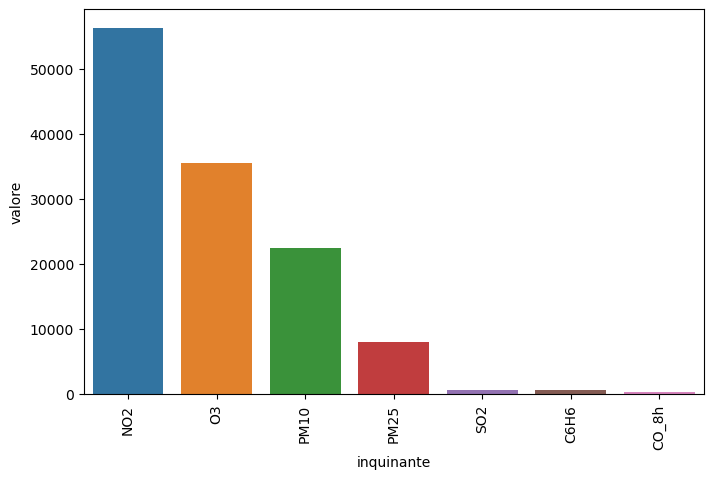

In [128]:
plt.figure(figsize = (8,5))
sns.barplot(data=df_grp, x="inquinante", y="valore", order=df_grp.sort_values("valore",ascending=False).inquinante)
plt.xticks(rotation=90)
plt.show()

## Gruppi su più variabili e indice multilivello

Ora complichiamo leggermente il grafico per avere non solo i totali parziali rispetto agli inquinanti, ma vogliamo avere <ins>i totali parziali divisi anche per mese, quindi, per ogni mese, quanti inquinanti</ins>. <br>
Serve ancora la `groupby()` ma questa volta rispetto alle due variabili, il mese, estratto dalla data, e `inquinanti`.

Per estrarre il mese dai valori di `data` (deve essere in formato datetime) ricorriamo alla funzione `dt.month` di pandas, logicamente analoga alla `Month()` della libreria lubridate di R.<br>
`df_py['data'].dt.month` ricava il valore del mese dai valori di `df_py['data']`.<br>
Questa è la modalità standard per usare valori della data in una `groupby()`.

In [208]:
df_grp2=df_py.groupby([df_py['data'].dt.month, "inquinante"])[["valore"]].sum()
df_grp2

valore
data inquinante        
1    C6H6         158.2
     CO_8h         87.4
     NO2         7428.0
     O3           840.0
     PM10        4738.0
...                 ...
9    NO2         5926.0
     O3          4337.0
     PM10        1773.0
     PM25         699.0
     SO2           83.0

[63 rows x 1 columns]

**Riportiamo il data frame da indicizzato a non indicizzato**

Per chiarezza rinominiamo anche la colonna `data` in `mese` con la funzione `rename()` di pandas.

In [214]:
df_grp2.reset_index(inplace=True)
df_grp2=df_grp2.rename(columns={"data":"mese"})
df_grp2

,mese,inquinante,valore
0,1,C6H6,158.2
1,1,CO_8h,87.4
2,1,NO2,7428.0
3,1,O3,840.0
4,1,PM10,4738.0
...,...,...,...
58,9,NO2,5926.0
59,9,O3,4337.0
60,9,PM10,1773.0
61,9,PM25,699.0


In [215]:
df_grp2.dtypes

mese            int64
inquinante     object
valore        float64
dtype: object

## Barplot con tre variabili

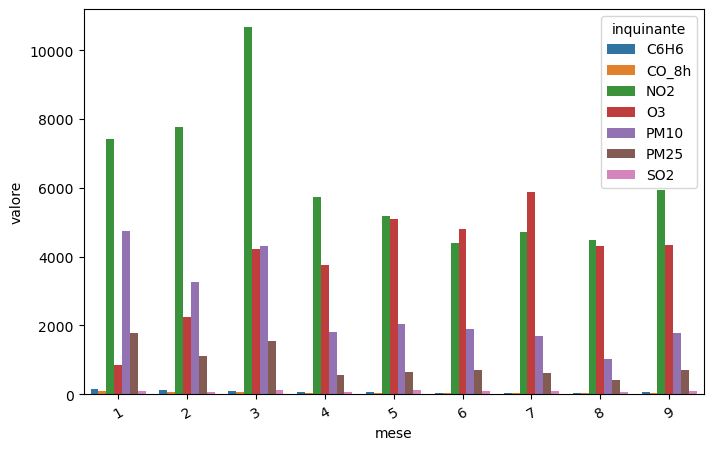

In [93]:
plt.figure(figsize = (8,5))
sns.barplot(data=df_grp2, x='mese', y="valore", hue="inquinante")
plt.xticks(rotation=30)
plt.show()

Miglioriamolo. Ad esempio:
- i mesi vogliamo che siano espressi con i nomi invece che con i numeri
- la legenda vogliamo spostarla fuori dal grafico

La colonna `mese` dobbiamo trasformarla in datetime perché è numerica.

In [217]:
df_grp2["mese"]=pd.to_datetime(df_grp2["mese"], format="%m")

Ora possiamo ricorrere a una funzione simile alla prcedente `dt.month`, la `dt.month_name()` che restituisce il nome del mese invece del numero.  <br>
Poi posizioniamo la legenda fuori dal grafico con i valori dell'opzione `bbox_to_anchor=`

**NOTA BENE:** Se si vuole posizionare la legenda <ins>in alto a destra appena fuori dal grafico</ins>, la combinazione `"upper left", bbox_to_anchor=(1, 1)` fa esattamente questo.

Provate altre combinazioni con `upper_left`, `upper_right`, `lower_left`, `lower_right` e diversi valori di `bbox_to_anchor=`

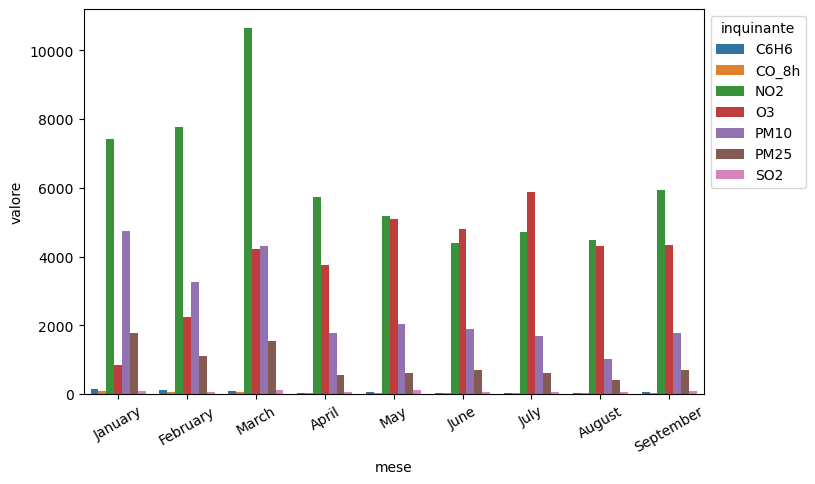

In [223]:
plt.figure(figsize = (8,5))

g=sns.barplot(data=df_grp2, x=df_grp2["mese"].dt.month_name(), y="valore", hue="inquinante")

plt.xticks(rotation=30)
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
plt.show()

Una nuova variante:
- scegliamo una color palette (`sns.color_palette()`)
- le barre sovrapposte invece di affiancate (opzione `dodge=False`)

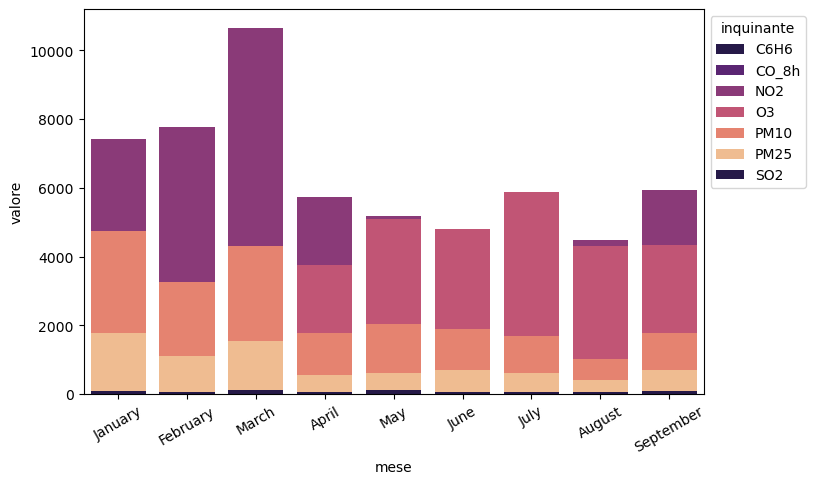

In [224]:
plt.figure(figsize = (8,5))

pal=sns.color_palette("magma")
g=sns.barplot(data=df_grp2, x=df_grp2["mese"].dt.month_name(), y="valore", 
              hue="inquinante", dodge=False, palette=pal)
plt.xticks(rotation=30)
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
plt.show()